## How have research topics in AI evolved over the last 10 years (2013- 2017 compared to 2018-2022)?

In [1]:
import re
import warnings
from pprint import pprint

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import tqdm
import nltk
import spacy
import gensim
import pyLDAvis
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired

import pyLDAvis.gensim
import gensim.corpora as corpora
from nltk.corpus import stopwords
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess
from wordcloud import WordCloud, STOPWORDS

import plotly.io as pio
pio.renderers.default = "svg"

%matplotlib inline
nltk.download("stopwords")
warnings.simplefilter("ignore")

stop_words = stopwords.words("english")

/Users/akindolieoluwatayo/Desktop/school/ai-ds/applied_ai/venv/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/akindolieoluwatayo/Desktop/school/ai-ds/applied_ai/venv/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/akindol

In [2]:
!python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 12.4 MB/s eta 0:00:00m eta 0:00:010:00:01

[notice] A new release of pip available: 22.2.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [3]:
df = pd.read_csv("./processed.csv")
df["publish_date"] = pd.to_datetime(df["publish_date"])

df.head()

,categories,title,abstract,publish_date
0,cs.CV,A Semi-automated Statistical Algorithm for Obj...,We explicate a semi-automated statistical al...,2013-01-01 19:51:28+00:00
1,cs.CV,Classifier Fusion Method to Recognize Handwrit...,Optical Character Recognition (OCR) is one o...,2013-01-02 04:45:44+00:00
2,cs.LG,A Novel Design Specification Distance(DSD) Bas...,Organizing data into semantically more meani...,2013-01-02 07:13:19+00:00
3,cs.AI,Applying Strategic Multiagent Planning to Real...,"Travel sharing, i.e., the problem of finding...",2013-01-02 12:06:59+00:00
4,cs.CV,A Self-Organizing Neural Scheme for Door Detec...,Doors are important landmarks for indoor mob...,2013-01-03 12:04:28+00:00


## Helper functions

In [4]:
def lemmatize(tokens):
    lemmatized = []

    for word in tokens:
        for token in nlp(word):
            lemmatized.append(token.lemma_)

    return lemmatized


def preprocess(text):
    # remove punctuations, convert to lowercase and tokenize
    tokens = simple_preprocess(text, deacc=True)

    # lemmatize
    doc = nlp(" ".join(tokens))

    # remove stopwords
    return [token.lemma_ for token in doc if token.text not in stop_words]

def plot_wordcloud(data):
    text = " ".join(data)
    wordcloud = WordCloud(background_color="#FFF").generate(text)

    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

def create_term_doc_freq(processed_series):
    id2word = corpora.Dictionary(processed_series)
    corpus = [id2word.doc2bow(text) for text in processed_series]

    return id2word, processed_series, corpus

def generate_samples(df, n=10000):
    samples = []
    sample_counts = (df["categories"].value_counts(normalize=True) * n).round().astype(int)

    for cat, count in sample_counts.items():
        cat_sample = df[df["categories"] == cat].sample(count, random_state=42)
        samples.append(cat_sample)

    return pd.concat(samples, axis=0).reset_index(drop=True)

## EDA

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84013 entries, 0 to 84012
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   categories    84013 non-null  object             
 1   title         84013 non-null  object             
 2   abstract      84013 non-null  object             
 3   publish_date  84013 non-null  datetime64[ns, GMT]
dtypes: datetime64[ns, GMT](1), object(3)
memory usage: 2.6+ MB


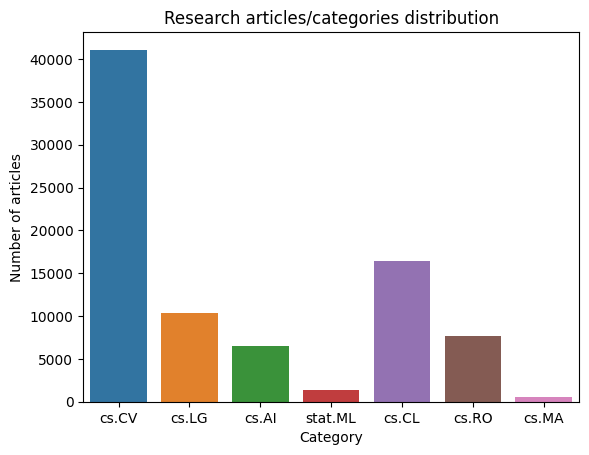

In [6]:
# cs.LG = Machine Learning, cs.CV = Computer Vision and Pattern Recognition, cs.AI = Artificial Intelligence
# cs.CL = Computation and Language (NLP), cs.RO = Robotics, cs.MA = Multiagent Systems, stat.ML = Machine Learning

sns.countplot(data=df, x="categories").set(title="Research articles/categories distribution")
plt.xlabel("Category")
plt.ylabel("Number of articles")
plt.show()

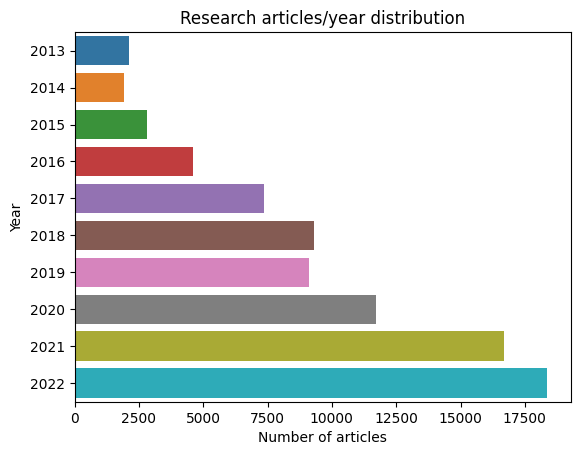

In [7]:
sns.countplot(data=df, y=df["publish_date"].dt.year).set(title="Research articles/year distribution")
plt.xlabel("Number of articles")
plt.ylabel("Year")
plt.show()

## Preprocessing

In [8]:
# combine title and abstract
df["combined_text"] = df["title"] + ' ' + df["abstract"]
df.head()

,categories,title,abstract,publish_date,combined_text
0,cs.CV,A Semi-automated Statistical Algorithm for Obj...,We explicate a semi-automated statistical al...,2013-01-01 19:51:28+00:00,A Semi-automated Statistical Algorithm for Obj...
1,cs.CV,Classifier Fusion Method to Recognize Handwrit...,Optical Character Recognition (OCR) is one o...,2013-01-02 04:45:44+00:00,Classifier Fusion Method to Recognize Handwrit...
2,cs.LG,A Novel Design Specification Distance(DSD) Bas...,Organizing data into semantically more meani...,2013-01-02 07:13:19+00:00,A Novel Design Specification Distance(DSD) Bas...
3,cs.AI,Applying Strategic Multiagent Planning to Real...,"Travel sharing, i.e., the problem of finding...",2013-01-02 12:06:59+00:00,Applying Strategic Multiagent Planning to Real...
4,cs.CV,A Self-Organizing Neural Scheme for Door Detec...,Doors are important landmarks for indoor mob...,2013-01-03 12:04:28+00:00,A Self-Organizing Neural Scheme for Door Detec...


In [9]:
df["publish_date"].dt.year.unique()

array([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022],
      dtype=int32)

In [10]:
df_first_5_full = df[df["publish_date"].dt.year <= 2017]
df_last_5_full = df[df["publish_date"].dt.year >= 2018]

In [11]:
print(df_first_5_full["publish_date"].dt.year.unique())
print(df_last_5_full["publish_date"].dt.year.unique())

[2013 2014 2015 2016 2017]
[2018 2019 2020 2021 2022]


In [12]:
df_first_5 = generate_samples(df_first_5_full)
df_first_5.head()

,categories,title,abstract,publish_date,combined_text
0,cs.CV,Latent Embeddings for Zero-shot Classification,We present a novel latent embedding model fo...,2016-03-29 19:24:38+00:00,Latent Embeddings for Zero-shot Classification...
1,cs.CV,Transfer Learning by Ranking for Weakly Superv...,Most existing approaches to training object ...,2017-05-02 09:23:27+00:00,Transfer Learning by Ranking for Weakly Superv...
2,cs.CV,Inference of Haemoglobin Concentration From St...,Multispectral imaging (MSI) can provide info...,2016-07-11 13:29:54+00:00,Inference of Haemoglobin Concentration From St...
3,cs.CV,Drought Stress Classification using 3D Plant M...,Quantification of physiological changes in p...,2017-09-21 05:20:13+00:00,Drought Stress Classification using 3D Plant M...
4,cs.CV,Predictive Learning: Using Future Representati...,The unsupervised Pretraining method has been...,2017-11-25 17:43:12+00:00,Predictive Learning: Using Future Representati...


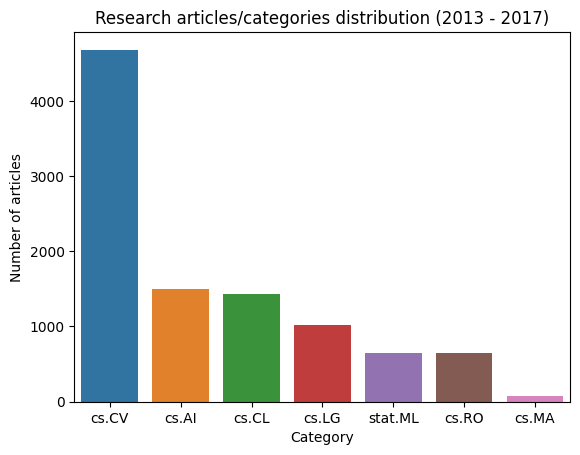

In [13]:
sns.countplot(data=df_first_5, x="categories").set(title="Research articles/categories distribution (2013 - 2017)")
plt.xlabel("Category")
plt.ylabel("Number of articles")
plt.show()

In [14]:
df_last_5 = generate_samples(df_last_5_full)
df_last_5.head()

,categories,title,abstract,publish_date,combined_text
0,cs.CV,Object-Centric Multi-View Aggregation,We present an approach for aggregating a spa...,2020-07-20 17:38:31+00:00,Object-Centric Multi-View Aggregation We pre...
1,cs.CV,Domain Adaptive 3D Pose Augmentation for In-th...,The ability to perceive 3D human bodies from...,2022-06-21 15:02:31+00:00,Domain Adaptive 3D Pose Augmentation for In-th...
2,cs.CV,Domain-General Crowd Counting in Unseen Scenarios,Domain shift across crowd data severely hind...,2022-12-05 19:52:28+00:00,Domain-General Crowd Counting in Unseen Scenar...
3,cs.CV,Learning to Transfer Texture from Clothing Ima...,"In this paper, we present a simple yet effec...",2020-03-04 12:53:58+00:00,Learning to Transfer Texture from Clothing Ima...
4,cs.CV,Crowd Density Estimation using Novel Feature D...,Crowd density estimation is an important tas...,2019-05-15 00:00:59+00:00,Crowd Density Estimation using Novel Feature D...


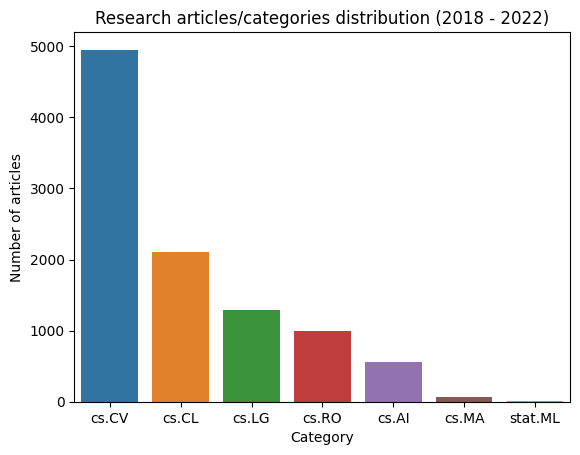

In [15]:
sns.countplot(data=df_last_5, x="categories").set(title="Research articles/categories distribution (2018 - 2022)")
plt.xlabel("Category")
plt.ylabel("Number of articles")
plt.show()

In [16]:
%%time

df_first_5["processed_text"] = df_first_5["combined_text"].apply(preprocess)
df_first_5.head()

CPU times: user 3min 20s, sys: 16.2 s, total: 3min 37s
Wall time: 3min 38s


,categories,title,abstract,publish_date,combined_text,processed_text
0,cs.CV,Latent Embeddings for Zero-shot Classification,We present a novel latent embedding model fo...,2016-03-29 19:24:38+00:00,Latent Embeddings for Zero-shot Classification...,"[latent, embedding, zero, shot, classification..."
1,cs.CV,Transfer Learning by Ranking for Weakly Superv...,Most existing approaches to training object ...,2017-05-02 09:23:27+00:00,Transfer Learning by Ranking for Weakly Superv...,"[transfer, learn, rank, weakly, supervise, obj..."
2,cs.CV,Inference of Haemoglobin Concentration From St...,Multispectral imaging (MSI) can provide info...,2016-07-11 13:29:54+00:00,Inference of Haemoglobin Concentration From St...,"[inference, haemoglobin, concentration, stereo..."
3,cs.CV,Drought Stress Classification using 3D Plant M...,Quantification of physiological changes in p...,2017-09-21 05:20:13+00:00,Drought Stress Classification using 3D Plant M...,"[drought, stress, classification, use, plant, ..."
4,cs.CV,Predictive Learning: Using Future Representati...,The unsupervised Pretraining method has been...,2017-11-25 17:43:12+00:00,Predictive Learning: Using Future Representati...,"[predictive, learning, use, future, representa..."


In [17]:
%%time

df_last_5["processed_text"] = df_last_5["combined_text"].apply(preprocess)
df_last_5.head()

CPU times: user 3min 35s, sys: 17.8 s, total: 3min 53s
Wall time: 3min 55s


,categories,title,abstract,publish_date,combined_text,processed_text
0,cs.CV,Object-Centric Multi-View Aggregation,We present an approach for aggregating a spa...,2020-07-20 17:38:31+00:00,Object-Centric Multi-View Aggregation We pre...,"[object, centric, multi, view, aggregation, pr..."
1,cs.CV,Domain Adaptive 3D Pose Augmentation for In-th...,The ability to perceive 3D human bodies from...,2022-06-21 15:02:31+00:00,Domain Adaptive 3D Pose Augmentation for In-th...,"[domain, adaptive, pose, augmentation, wild, h..."
2,cs.CV,Domain-General Crowd Counting in Unseen Scenarios,Domain shift across crowd data severely hind...,2022-12-05 19:52:28+00:00,Domain-General Crowd Counting in Unseen Scenar...,"[domain, general, crowd, count, unseen, scenar..."
3,cs.CV,Learning to Transfer Texture from Clothing Ima...,"In this paper, we present a simple yet effec...",2020-03-04 12:53:58+00:00,Learning to Transfer Texture from Clothing Ima...,"[learn, transfer, texture, clothing, image, hu..."
4,cs.CV,Crowd Density Estimation using Novel Feature D...,Crowd density estimation is an important tas...,2019-05-15 00:00:59+00:00,Crowd Density Estimation using Novel Feature D...,"[crowd, density, estimation, use, novel, featu..."


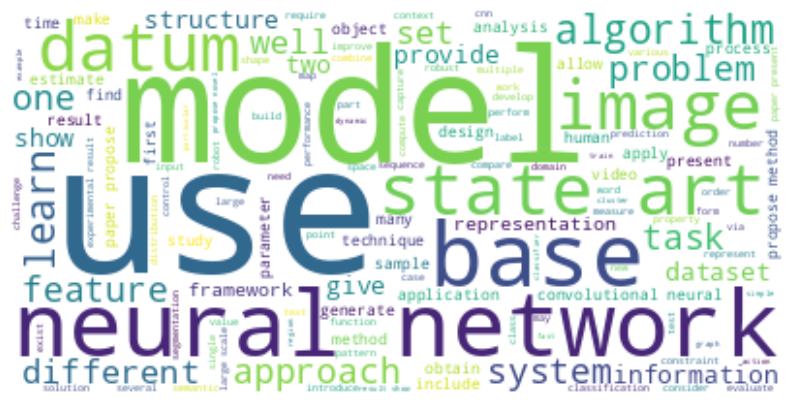

In [18]:
# Word Cloud (2013 - 2017)
plot_wordcloud([" ".join(sublist) for sublist in df_first_5["processed_text"]])

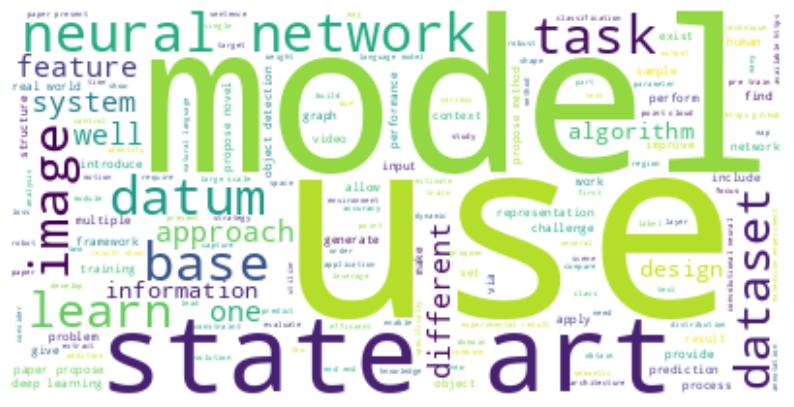

In [19]:
# Word Cloud (2018 - 2022)
plot_wordcloud([" ".join(sublist) for sublist in df_last_5["processed_text"]])

## LDA

In [20]:
id2word_first_5, processed_series_first_5, corpus_first_5 = create_term_doc_freq(df_first_5["processed_text"])
id2word_last_5, processed_series_last_5, corpus_last_5 = create_term_doc_freq(df_last_5["processed_text"])

In [21]:
def runLDAModel(corpus, id2word, processed_series, num_topics, alpha="symmetric", eta=None):
    lda_model = gensim.models.ldamodel.LdaModel(
        eta=eta,
        passes=10,
        alpha=alpha,
        corpus=corpus,
        chunksize=200,
        id2word=id2word,
        random_state=100,
        per_word_topics=True,
        num_topics=num_topics
    )

    # Print the keyword of topics
    # pprint(lda_model.print_topics())
    # doc_lda = lda_model[corpus]

    # validation
    coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_series, dictionary=id2word, coherence="c_v")
    coherence_lda = coherence_model_lda.get_coherence()
    
    print(f"Coherence score: {coherence_lda}")
    
    return lda_model, coherence_lda

def lda_hyperparameter_grid_search(num_topics_range, corpus, id2word, processed_series):
    results = {"num_topics": [], "alpha": [], "beta": [], "coherence_val": []}
    progress_bar = tqdm.tqdm(total=60)

    alpha = [0.01, 0.1, 0.5, "symmetric", "asymmetric"]
    beta = [0.01, 0.1, 0.5, "symmetric"]

    for num_topic in num_topics_range:
        for a in alpha:
            for b in beta:
                model, coherence_val = runLDAModel(corpus, id2word, processed_series, num_topic, a, b)
                
                results["beta"].append(b)
                results["alpha"].append(a)
                results["num_topics"].append(num_topic)
                results["coherence_val"].append(coherence_val)
                
                progress_bar.update(1)
        
    
    progress_bar.close()
    return results

def visualize_topics(cloud, topics):
    fig, axes = plt.subplots(3, 3, figsize=(12, 8), sharex=True, sharey=True)
    
    for i, ax in enumerate(axes.flatten()):
        if i in range(len(topics)):
            topic_words = dict(topics[i][1])
            cloud.generate_from_frequencies(topic_words, max_font_size=250)
            
            ax.imshow(cloud)
            ax.set_title(f"Topic {i}", fontdict=dict(size=20))
            ax.axis("off")

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis("off")
    plt.margins(x=0, y=0)
    plt.tight_layout()
    plt.show()

def calculate_bert_coherence_val(model, processed_series, id2word):
    topic_words = {}
    
    for topic in model.get_topics():
        if topic == -1:
            continue
            
        if topic >= 10:
            break
    
        words = [word[0] for word in model.get_topic(topic)]
        topic_words[topic] = words
    
    cm = CoherenceModel(topics=list(topic_words.values()), texts=processed_series, dictionary=id2word, coherence='c_v')
    return cm.get_coherence()

In [22]:
%%time

# compute coherence values for first & last 5 years
model_list_first_5 = []
model_list_last_5 = []
coherence_values_first_5 = []
coherence_values_last_5 = []

range_of_topic_len = range(5, 20)

for num_topics in range_of_topic_len:
    print("*" * 20)
    print(f"Number of topics: {num_topics}")
    
    model_first_5, coherence_val_first_5 = runLDAModel(corpus_first_5, id2word_first_5, processed_series_first_5, num_topics)
    print("-" * 10)
    model_last_5, coherence_val_last_5 = runLDAModel(corpus_last_5, id2word_last_5, processed_series_last_5, num_topics)

    model_list_first_5.append(model_first_5)
    model_list_last_5.append(model_last_5)
    coherence_values_first_5.append(coherence_val_first_5)
    coherence_values_last_5.append(coherence_val_last_5)

********************
Number of topics: 5
Coherence score: 0.395551651703819
----------
Coherence score: 0.3752356952972723
********************
Number of topics: 6
Coherence score: 0.3737379641068758
----------
Coherence score: 0.39481870112599743
********************
Number of topics: 7
Coherence score: 0.39560063925092376
----------
Coherence score: 0.41146616541202885
********************
Number of topics: 8
Coherence score: 0.377362949941829
----------
Coherence score: 0.40120591285497986
********************
Number of topics: 9
Coherence score: 0.35307592307982655
----------
Coherence score: 0.36132800845800084
********************
Number of topics: 10
Coherence score: 0.3902160107742336
----------
Coherence score: 0.378818053478157
********************
Number of topics: 11
Coherence score: 0.38922059553673377
----------
Coherence score: 0.37651008041474615
********************
Number of topics: 12
Coherence score: 0.39301206579461806
----------
Coherence score: 0.3699036024712298

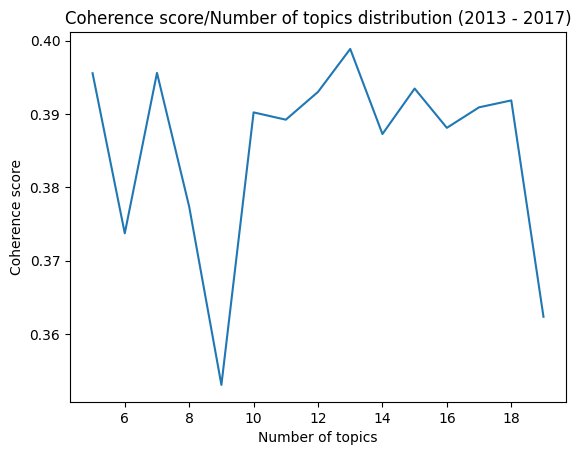

In [23]:
plt.plot(range_of_topic_len, coherence_values_first_5)
plt.xlabel("Number of topics")
plt.ylabel("Coherence score")
plt.title("Coherence score/Number of topics distribution (2013 - 2017)")
plt.show()

In [24]:
for n, cv in zip(range_of_topic_len, coherence_values_first_5):
    print(f"Num of topics: {n}, Coherence val: {cv}")

# 12, 13, 14

Num of topics: 5, Coherence val: 0.395551651703819
Num of topics: 6, Coherence val: 0.3737379641068758
Num of topics: 7, Coherence val: 0.39560063925092376
Num of topics: 8, Coherence val: 0.377362949941829
Num of topics: 9, Coherence val: 0.35307592307982655
Num of topics: 10, Coherence val: 0.3902160107742336
Num of topics: 11, Coherence val: 0.38922059553673377
Num of topics: 12, Coherence val: 0.39301206579461806
Num of topics: 13, Coherence val: 0.3988648718484793
Num of topics: 14, Coherence val: 0.38726787818645425
Num of topics: 15, Coherence val: 0.3934640667012211
Num of topics: 16, Coherence val: 0.38810954370877915
Num of topics: 17, Coherence val: 0.39090726812972154
Num of topics: 18, Coherence val: 0.39184759844702977
Num of topics: 19, Coherence val: 0.3623589655156968


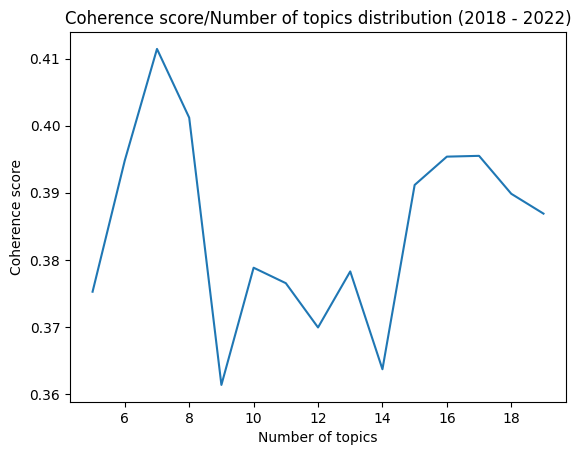

In [25]:
plt.plot(range_of_topic_len, coherence_values_last_5)
plt.xlabel("Number of topics")
plt.ylabel("Coherence score")
plt.title("Coherence score/Number of topics distribution (2018 - 2022)")
plt.show()

In [26]:
for n, cv in zip(range_of_topic_len, coherence_values_last_5):
    print(f"Num of topics: {n}, Coherence val: {cv}")

# 6, 7, 8

Num of topics: 5, Coherence val: 0.3752356952972723
Num of topics: 6, Coherence val: 0.39481870112599743
Num of topics: 7, Coherence val: 0.41146616541202885
Num of topics: 8, Coherence val: 0.40120591285497986
Num of topics: 9, Coherence val: 0.36132800845800084
Num of topics: 10, Coherence val: 0.378818053478157
Num of topics: 11, Coherence val: 0.37651008041474615
Num of topics: 12, Coherence val: 0.36990360247122983
Num of topics: 13, Coherence val: 0.37826235442933837
Num of topics: 14, Coherence val: 0.3636674034486518
Num of topics: 15, Coherence val: 0.3911653840650169
Num of topics: 16, Coherence val: 0.395392857390121
Num of topics: 17, Coherence val: 0.39551065442715033
Num of topics: 18, Coherence val: 0.3898504091928091
Num of topics: 19, Coherence val: 0.3868895538633237


### Hyperparameter tuning

In [27]:
%%time

results_first_5 = lda_hyperparameter_grid_search(range(12, 15), corpus_first_5, id2word_first_5, processed_series_first_5)
results_first_5

  2%|█▍                                                                                       | 1/60 [01:03<1:02:10, 63.23s/it]

Coherence score: 0.3807209421198953


  3%|███                                                                                        | 2/60 [02:00<57:50, 59.83s/it]

Coherence score: 0.3851303692795958


  5%|████▌                                                                                      | 3/60 [03:00<56:38, 59.62s/it]

Coherence score: 0.5147273222934027


  7%|██████                                                                                     | 4/60 [03:58<55:14, 59.19s/it]

Coherence score: 0.40246772888911986


  8%|███████▌                                                                                   | 5/60 [05:01<55:31, 60.58s/it]

Coherence score: 0.3836133737456994


 10%|█████████                                                                                  | 6/60 [05:58<53:29, 59.43s/it]

Coherence score: 0.3895630403695098


 12%|██████████▌                                                                                | 7/60 [06:57<52:18, 59.22s/it]

Coherence score: 0.48575988093590894


 13%|████████████▏                                                                              | 8/60 [07:55<50:52, 58.70s/it]

Coherence score: 0.3892393760147456


 15%|█████████████▋                                                                             | 9/60 [08:55<50:26, 59.35s/it]

Coherence score: 0.3886963385169831


 17%|███████████████                                                                           | 10/60 [09:52<48:45, 58.51s/it]

Coherence score: 0.39160606831231


 18%|████████████████▌                                                                         | 11/60 [10:55<48:56, 59.93s/it]

Coherence score: 0.4393551581482378


 20%|██████████████████                                                                        | 12/60 [11:53<47:28, 59.35s/it]

Coherence score: 0.380576586596406


 22%|███████████████████▌                                                                      | 13/60 [12:57<47:27, 60.59s/it]

Coherence score: 0.37769673552180066


 23%|█████████████████████                                                                     | 14/60 [13:55<45:51, 59.82s/it]

Coherence score: 0.38682493032376647


 25%|██████████████████████▌                                                                   | 15/60 [14:55<44:52, 59.82s/it]

Coherence score: 0.5018231985910063


 27%|████████████████████████                                                                  | 16/60 [15:54<43:50, 59.79s/it]

Coherence score: 0.39301206579461806


 28%|█████████████████████████▌                                                                | 17/60 [16:59<43:48, 61.13s/it]

Coherence score: 0.3805533175896605


 30%|███████████████████████████                                                               | 18/60 [17:57<42:18, 60.45s/it]

Coherence score: 0.3944864519819276


 32%|████████████████████████████▌                                                             | 19/60 [18:59<41:28, 60.69s/it]

Coherence score: 0.4873486008972805


 33%|██████████████████████████████                                                            | 20/60 [19:58<40:11, 60.29s/it]

Coherence score: 0.3963615275574637


 35%|███████████████████████████████▍                                                          | 21/60 [21:05<40:24, 62.16s/it]

Coherence score: 0.3791672775801235


 37%|█████████████████████████████████                                                         | 22/60 [22:06<39:18, 62.05s/it]

Coherence score: 0.37881889449593237


 38%|██████████████████████████████████▌                                                       | 23/60 [23:08<38:10, 61.91s/it]

Coherence score: 0.4658587501560675


 40%|████████████████████████████████████                                                      | 24/60 [24:12<37:27, 62.42s/it]

Coherence score: 0.40935837364850414


 42%|█████████████████████████████████████▌                                                    | 25/60 [25:18<37:04, 63.55s/it]

Coherence score: 0.38140659097810015


 43%|███████████████████████████████████████                                                   | 26/60 [26:18<35:29, 62.63s/it]

Coherence score: 0.3919735506452699


 45%|████████████████████████████████████████▌                                                 | 27/60 [27:20<34:15, 62.28s/it]

Coherence score: 0.47672477163614013


 47%|██████████████████████████████████████████                                                | 28/60 [28:21<33:08, 62.13s/it]

Coherence score: 0.3959236592280648


 48%|███████████████████████████████████████████▌                                              | 29/60 [29:24<32:13, 62.37s/it]

Coherence score: 0.4011244586922705


 50%|█████████████████████████████████████████████                                             | 30/60 [30:25<30:52, 61.74s/it]

Coherence score: 0.38391386213826745


 52%|██████████████████████████████████████████████▌                                           | 31/60 [31:29<30:13, 62.54s/it]

Coherence score: 0.4550368755427842


 53%|████████████████████████████████████████████████                                          | 32/60 [32:29<28:52, 61.87s/it]

Coherence score: 0.4092251052834723


 55%|█████████████████████████████████████████████████▌                                        | 33/60 [33:34<28:15, 62.81s/it]

Coherence score: 0.38657353526212684


 57%|███████████████████████████████████████████████████                                       | 34/60 [34:35<26:54, 62.08s/it]

Coherence score: 0.385827420251355


 58%|████████████████████████████████████████████████████▌                                     | 35/60 [35:35<25:36, 61.48s/it]

Coherence score: 0.4562128694724477


 60%|██████████████████████████████████████████████████████                                    | 36/60 [36:36<24:35, 61.49s/it]

Coherence score: 0.3988648718484793


 62%|███████████████████████████████████████████████████████▌                                  | 37/60 [37:41<23:56, 62.46s/it]

Coherence score: 0.37908206910333964


 63%|█████████████████████████████████████████████████████████                                 | 38/60 [38:40<22:30, 61.37s/it]

Coherence score: 0.38340596921931397


 65%|██████████████████████████████████████████████████████████▌                               | 39/60 [39:42<21:35, 61.67s/it]

Coherence score: 0.5090384033722102


 67%|████████████████████████████████████████████████████████████                              | 40/60 [40:44<20:32, 61.60s/it]

Coherence score: 0.41038448252544296


 68%|█████████████████████████████████████████████████████████████▌                            | 41/60 [41:50<19:58, 63.08s/it]

Coherence score: 0.3637311487086648


 70%|██████████████████████████████████████████████████████████████▉                           | 42/60 [42:51<18:41, 62.28s/it]

Coherence score: 0.3609887319985661


 72%|████████████████████████████████████████████████████████████████▌                         | 43/60 [43:54<17:43, 62.59s/it]

Coherence score: 0.4784801843284642


 73%|██████████████████████████████████████████████████████████████████                        | 44/60 [44:57<16:41, 62.58s/it]

Coherence score: 0.3865649782617161


 75%|███████████████████████████████████████████████████████████████████▌                      | 45/60 [46:02<15:52, 63.49s/it]

Coherence score: 0.3864898099218163


 77%|█████████████████████████████████████████████████████████████████████                     | 46/60 [47:01<14:31, 62.23s/it]

Coherence score: 0.36991254616319014


 78%|██████████████████████████████████████████████████████████████████████▌                   | 47/60 [48:04<13:29, 62.25s/it]

Coherence score: 0.4922152253337681


 80%|████████████████████████████████████████████████████████████████████████                  | 48/60 [49:06<12:26, 62.17s/it]

Coherence score: 0.38312076070769024


 82%|█████████████████████████████████████████████████████████████████████████▌                | 49/60 [50:10<11:30, 62.76s/it]

Coherence score: 0.3944738990730073


 83%|███████████████████████████████████████████████████████████████████████████               | 50/60 [51:10<10:19, 61.97s/it]

Coherence score: 0.403315678777122


 85%|████████████████████████████████████████████████████████████████████████████▌             | 51/60 [52:14<09:24, 62.74s/it]

Coherence score: 0.4657032932766882


 87%|██████████████████████████████████████████████████████████████████████████████            | 52/60 [53:16<08:18, 62.26s/it]

Coherence score: 0.3966244080839152


 88%|███████████████████████████████████████████████████████████████████████████████▌          | 53/60 [54:22<07:24, 63.52s/it]

Coherence score: 0.3889624677584386


 90%|█████████████████████████████████████████████████████████████████████████████████         | 54/60 [55:21<06:12, 62.08s/it]

Coherence score: 0.3732728848644279


 92%|██████████████████████████████████████████████████████████████████████████████████▌       | 55/60 [56:23<05:10, 62.10s/it]

Coherence score: 0.48895727533388894


 93%|████████████████████████████████████████████████████████████████████████████████████      | 56/60 [57:25<04:07, 61.99s/it]

Coherence score: 0.38726787818645425


 95%|█████████████████████████████████████████████████████████████████████████████████████▌    | 57/60 [58:31<03:09, 63.33s/it]

Coherence score: 0.36858191868586837


 97%|███████████████████████████████████████████████████████████████████████████████████████   | 58/60 [59:32<02:05, 62.57s/it]

Coherence score: 0.3705137327804154


 98%|██████████████████████████████████████████████████████████████████████████████████████▌ | 59/60 [1:00:37<01:03, 63.26s/it]

Coherence score: 0.4851039561867611


100%|████████████████████████████████████████████████████████████████████████████████████████| 60/60 [1:01:40<00:00, 61.67s/it]

Coherence score: 0.3829312162959328
CPU times: user 51min 56s, sys: 43.3 s, total: 52min 39s
Wall time: 1h 1min 40s


{'num_topics': [12,
  12,
  12,
  12,
  12,
  12,
  12,
  12,
  12,
  12,
  12,
  12,
  12,
  12,
  12,
  12,
  12,
  12,
  12,
  12,
  13,
  13,
  13,
  13,
  13,
  13,
  13,
  13,
  13,
  13,
  13,
  13,
  13,
  13,
  13,
  13,
  13,
  13,
  13,
  13,
  14,
  14,
  14,
  14,
  14,
  14,
  14,
  14,
  14,
  14,
  14,
  14,
  14,
  14,
  14,
  14,
  14,
  14,
  14,
  14],
 'alpha': [0.01,
  0.01,
  0.01,
  0.01,
  0.1,
  0.1,
  0.1,
  0.1,
  0.5,
  0.5,
  0.5,
  0.5,
  'symmetric',
  'symmetric',
  'symmetric',
  'symmetric',
  'asymmetric',
  'asymmetric',
  'asymmetric',
  'asymmetric',
  0.01,
  0.01,
  0.01,
  0.01,
  0.1,
  0.1,
  0.1,
  0.1,
  0.5,
  0.5,
  0.5,
  0.5,
  'symmetric',
  'symmetric',
  'symmetric',
  'symmetric',
  'asymmetric',
  'asymmetric',
  'asymmetric',
  'asymmetric',
  0.01,
  0.01,
  0.01,
  0.01,
  0.1,
  0.1,
  0.1,
  0.1,
  0.5,
  0.5,
  0.5,
  0.5,
  'symmetric',
  'symmetric',
  'symmetric',
  'symmetric',
  'asymmetric',
  'asymmetric',
  'asymmetri

In [28]:
results_first_5_df = pd.DataFrame(results_first_5)
results_first_5_df

,num_topics,alpha,beta,coherence_val
0,12,0.01,0.01,0.380721
1,12,0.01,0.1,0.385130
2,12,0.01,0.5,0.514727
3,12,0.01,symmetric,0.402468
4,12,0.1,0.01,0.383613
5,12,0.1,0.1,0.389563
6,12,0.1,0.5,0.485760
7,12,0.1,symmetric,0.389239
8,12,0.5,0.01,0.388696
9,12,0.5,0.1,0.391606


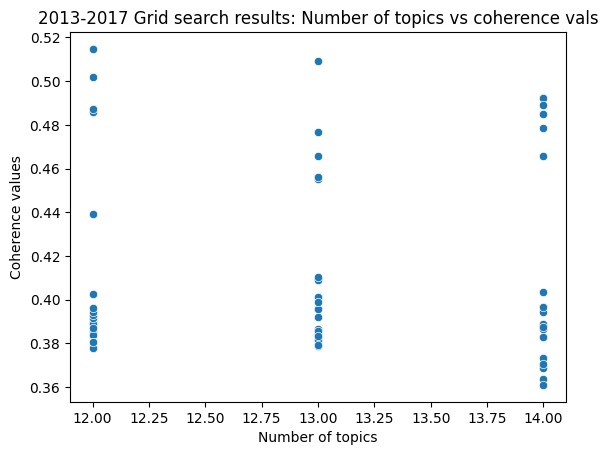

In [29]:
sns.scatterplot(x=results_first_5_df["num_topics"], y=results_first_5_df["coherence_val"])

plt.xlabel("Number of topics")
plt.ylabel("Coherence values")
plt.title("2013-2017 Grid search results: Number of topics vs coherence vals")
plt.show()

In [30]:
# best grid search result for 2013 - 2017
best_config_index = results_first_5["coherence_val"].index(max(results_first_5["coherence_val"]))

print("beta:", results_first_5["beta"][best_config_index])
print("alpha:", results_first_5["alpha"][best_config_index])
print("num of topics:", results_first_5["num_topics"][best_config_index])
print("best coherence val:", max(results_first_5["coherence_val"]))

beta: 0.5
alpha: 0.01
num of topics: 12
best coherence val: 0.5147273222934027


In [31]:
%%time

results_last_5 = lda_hyperparameter_grid_search(range(6, 9), corpus_last_5, id2word_last_5, processed_series_last_5)
results_last_5

  2%|█▍                                                                                       | 1/60 [01:01<1:00:15, 61.28s/it]

Coherence score: 0.3462882734699971


  3%|███                                                                                        | 2/60 [01:56<55:59, 57.92s/it]

Coherence score: 0.3877718674794495


  5%|████▌                                                                                      | 3/60 [03:01<58:00, 61.06s/it]

Coherence score: 0.4519640833203284


  7%|██████                                                                                     | 4/60 [03:57<55:03, 58.99s/it]

Coherence score: 0.39573691334524996


  8%|███████▌                                                                                   | 5/60 [04:58<54:39, 59.62s/it]

Coherence score: 0.35898153087147144


 10%|█████████                                                                                  | 6/60 [05:54<52:38, 58.49s/it]

Coherence score: 0.40763848976824185


 12%|██████████▌                                                                                | 7/60 [06:57<53:01, 60.02s/it]

Coherence score: 0.44638537085459906


 13%|████████████▏                                                                              | 8/60 [07:54<51:02, 58.89s/it]

Coherence score: 0.40588216287594103


 15%|█████████████▋                                                                             | 9/60 [08:55<50:46, 59.73s/it]

Coherence score: 0.3619611206363636


 17%|███████████████                                                                           | 10/60 [09:53<49:09, 58.99s/it]

Coherence score: 0.3829544957361049


 18%|████████████████▌                                                                         | 11/60 [10:57<49:27, 60.57s/it]

Coherence score: 0.37884525252048434


 20%|██████████████████                                                                        | 12/60 [11:55<47:49, 59.77s/it]

Coherence score: 0.37840723529129594


 22%|███████████████████▌                                                                      | 13/60 [12:56<47:13, 60.28s/it]

Coherence score: 0.36193948874214116


 23%|█████████████████████                                                                     | 14/60 [13:52<45:12, 58.97s/it]

Coherence score: 0.3831740738698442


 25%|██████████████████████▌                                                                   | 15/60 [14:56<45:17, 60.40s/it]

Coherence score: 0.4434287690159742


 27%|████████████████████████                                                                  | 16/60 [15:52<43:22, 59.14s/it]

Coherence score: 0.39481870112599743


 28%|█████████████████████████▌                                                                | 17/60 [16:53<42:45, 59.66s/it]

Coherence score: 0.346480643884502


 30%|███████████████████████████                                                               | 18/60 [17:49<41:04, 58.68s/it]

Coherence score: 0.37460900078539877


 32%|████████████████████████████▌                                                             | 19/60 [18:51<40:41, 59.56s/it]

Coherence score: 0.40373272347357453


 33%|██████████████████████████████                                                            | 20/60 [19:47<38:57, 58.44s/it]

Coherence score: 0.40457301041934907


 35%|███████████████████████████████▍                                                          | 21/60 [20:49<38:45, 59.62s/it]

Coherence score: 0.375461666832234


 37%|█████████████████████████████████                                                         | 22/60 [21:45<37:01, 58.46s/it]

Coherence score: 0.39481505833912994


 38%|██████████████████████████████████▌                                                       | 23/60 [22:46<36:35, 59.33s/it]

Coherence score: 0.4433959294759585


 40%|████████████████████████████████████                                                      | 24/60 [23:42<35:03, 58.43s/it]

Coherence score: 0.40698310237738156


 42%|█████████████████████████████████████▌                                                    | 25/60 [24:45<34:44, 59.55s/it]

Coherence score: 0.37716127952686435


 43%|███████████████████████████████████████                                                   | 26/60 [25:40<32:59, 58.21s/it]

Coherence score: 0.39774683691194174


 45%|████████████████████████████████████████▌                                                 | 27/60 [26:40<32:19, 58.79s/it]

Coherence score: 0.43981344390928534


 47%|██████████████████████████████████████████                                                | 28/60 [27:36<30:53, 57.93s/it]

Coherence score: 0.41693688187438915


 48%|███████████████████████████████████████████▌                                              | 29/60 [28:38<30:35, 59.22s/it]

Coherence score: 0.39318972462632457


 50%|█████████████████████████████████████████████                                             | 30/60 [29:36<29:21, 58.73s/it]

Coherence score: 0.3760944253456153


 52%|██████████████████████████████████████████████▌                                           | 31/60 [30:42<29:26, 60.93s/it]

Coherence score: 0.4101076096618468


 53%|████████████████████████████████████████████████                                          | 32/60 [31:41<28:09, 60.34s/it]

Coherence score: 0.38720268469831004


 55%|█████████████████████████████████████████████████▌                                        | 33/60 [32:42<27:20, 60.75s/it]

Coherence score: 0.37741109647223503


 57%|███████████████████████████████████████████████████                                       | 34/60 [33:37<25:34, 59.02s/it]

Coherence score: 0.402798047156583


 58%|████████████████████████████████████████████████████▌                                     | 35/60 [34:38<24:46, 59.48s/it]

Coherence score: 0.4492108413587802


 60%|██████████████████████████████████████████████████████                                    | 36/60 [35:34<23:20, 58.35s/it]

Coherence score: 0.41146616541202885


 62%|███████████████████████████████████████████████████████▌                                  | 37/60 [36:36<22:50, 59.57s/it]

Coherence score: 0.3538390245480207


 63%|█████████████████████████████████████████████████████████                                 | 38/60 [37:32<21:24, 58.39s/it]

Coherence score: 0.3923760971281829


 65%|██████████████████████████████████████████████████████████▌                               | 39/60 [38:32<20:38, 58.95s/it]

Coherence score: 0.4195540760678753


 67%|████████████████████████████████████████████████████████████                              | 40/60 [39:27<19:14, 57.73s/it]

Coherence score: 0.4129085949691305


 68%|█████████████████████████████████████████████████████████████▌                            | 41/60 [40:30<18:49, 59.44s/it]

Coherence score: 0.39355521396301796


 70%|██████████████████████████████████████████████████████████████▉                           | 42/60 [41:29<17:45, 59.22s/it]

Coherence score: 0.4089324407720697


 72%|████████████████████████████████████████████████████████████████▌                         | 43/60 [42:34<17:14, 60.84s/it]

Coherence score: 0.4655014813423214


 73%|██████████████████████████████████████████████████████████████████                        | 44/60 [43:32<16:02, 60.15s/it]

Coherence score: 0.38216789053188066


 75%|███████████████████████████████████████████████████████████████████▌                      | 45/60 [44:36<15:17, 61.17s/it]

Coherence score: 0.39783852878177456


 77%|█████████████████████████████████████████████████████████████████████                     | 46/60 [45:33<14:00, 60.02s/it]

Coherence score: 0.4022344271203572


 78%|██████████████████████████████████████████████████████████████████████▌                   | 47/60 [46:36<13:13, 61.05s/it]

Coherence score: 0.44513856283699765


 80%|████████████████████████████████████████████████████████████████████████                  | 48/60 [47:34<12:00, 60.05s/it]

Coherence score: 0.4047522404138


 82%|█████████████████████████████████████████████████████████████████████████▌                | 49/60 [48:38<11:13, 61.18s/it]

Coherence score: 0.38117597760354405


 83%|███████████████████████████████████████████████████████████████████████████               | 50/60 [49:36<10:03, 60.36s/it]

Coherence score: 0.3992000563009602


 85%|████████████████████████████████████████████████████████████████████████████▌             | 51/60 [50:42<09:18, 62.04s/it]

Coherence score: 0.4466397289170876


 87%|██████████████████████████████████████████████████████████████████████████████            | 52/60 [51:41<08:09, 61.15s/it]

Coherence score: 0.3883696757253589


 88%|███████████████████████████████████████████████████████████████████████████████▌          | 53/60 [52:45<07:12, 61.86s/it]

Coherence score: 0.399156336870107


 90%|█████████████████████████████████████████████████████████████████████████████████         | 54/60 [53:42<06:02, 60.49s/it]

Coherence score: 0.39852637699246124


 92%|██████████████████████████████████████████████████████████████████████████████████▌       | 55/60 [54:45<05:06, 61.29s/it]

Coherence score: 0.45852533625227443


 93%|████████████████████████████████████████████████████████████████████████████████████      | 56/60 [55:43<04:00, 60.19s/it]

Coherence score: 0.40120591285497986


 95%|█████████████████████████████████████████████████████████████████████████████████████▌    | 57/60 [56:46<03:02, 60.96s/it]

Coherence score: 0.37598225489843395


 97%|███████████████████████████████████████████████████████████████████████████████████████   | 58/60 [57:43<01:59, 59.92s/it]

Coherence score: 0.38799855579289644


 98%|████████████████████████████████████████████████████████████████████████████████████████▌ | 59/60 [58:45<01:00, 60.55s/it]

Coherence score: 0.41662051800915195


100%|██████████████████████████████████████████████████████████████████████████████████████████| 60/60 [59:43<00:00, 59.72s/it]

Coherence score: 0.3950490204689955
CPU times: user 50min 38s, sys: 32.3 s, total: 51min 10s
Wall time: 59min 43s


{'num_topics': [6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8],
 'alpha': [0.01,
  0.01,
  0.01,
  0.01,
  0.1,
  0.1,
  0.1,
  0.1,
  0.5,
  0.5,
  0.5,
  0.5,
  'symmetric',
  'symmetric',
  'symmetric',
  'symmetric',
  'asymmetric',
  'asymmetric',
  'asymmetric',
  'asymmetric',
  0.01,
  0.01,
  0.01,
  0.01,
  0.1,
  0.1,
  0.1,
  0.1,
  0.5,
  0.5,
  0.5,
  0.5,
  'symmetric',
  'symmetric',
  'symmetric',
  'symmetric',
  'asymmetric',
  'asymmetric',
  'asymmetric',
  'asymmetric',
  0.01,
  0.01,
  0.01,
  0.01,
  0.1,
  0.1,
  0.1,
  0.1,
  0.5,
  0.5,
  0.5,
  0.5,
  'symmetric',
  'symmetric',
  'symmetric',
  'symmetric',
  'asymmetric',
  'asymmetric',
  'asymmetric',
  'asymmetric'],
 'beta': [0.01,
  0.1,
  0.5,
  'symmet

In [32]:
results_last_5_df = pd.DataFrame(results_last_5)
results_last_5_df

,num_topics,alpha,beta,coherence_val
0,6,0.01,0.01,0.346288
1,6,0.01,0.1,0.387772
2,6,0.01,0.5,0.451964
3,6,0.01,symmetric,0.395737
4,6,0.1,0.01,0.358982
5,6,0.1,0.1,0.407638
6,6,0.1,0.5,0.446385
7,6,0.1,symmetric,0.405882
8,6,0.5,0.01,0.361961
9,6,0.5,0.1,0.382954


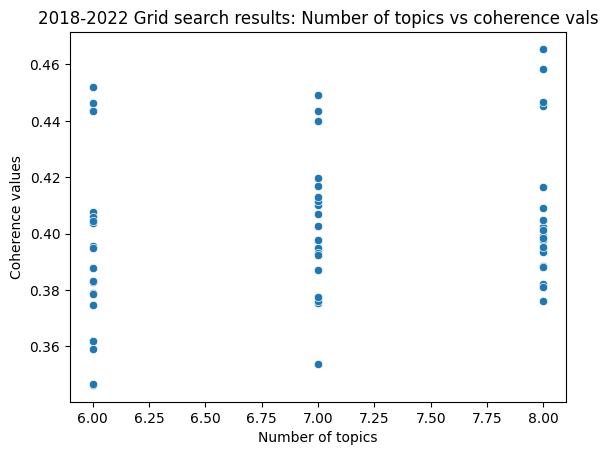

In [33]:
sns.scatterplot(x=results_last_5_df["num_topics"], y=results_last_5_df["coherence_val"])

plt.xlabel("Number of topics")
plt.ylabel("Coherence values")
plt.title("2018-2022 Grid search results: Number of topics vs coherence vals")
plt.show()

In [34]:
# best grid search result for 2018 - 2022
best_config_index = results_last_5["coherence_val"].index(max(results_last_5["coherence_val"]))

print("beta:", results_last_5["beta"][best_config_index])
print("alpha:", results_last_5["alpha"][best_config_index])
print("num of topics:", results_last_5["num_topics"][best_config_index])
print("best coherence val:", max(results_last_5["coherence_val"]))

beta: 0.5
alpha: 0.01
num of topics: 8
best coherence val: 0.4655014813423214


In [35]:
%%time

# best model 2013 - 2017
model_first_5, coherence_val_first_5 = runLDAModel(corpus_first_5, id2word_first_5, processed_series_first_5, 12, 0.01, 0.5)

Coherence score: 0.5147273222934027
CPU times: user 51.4 s, sys: 533 ms, total: 51.9 s
Wall time: 1min


In [36]:
%%time

#best model 2018 - 2022
model_last_5, coherence_val_last_5 = runLDAModel(corpus_last_5, id2word_last_5, processed_series_last_5, 8, 0.01, 0.5)

Coherence score: 0.4655014813423214
CPU times: user 55.3 s, sys: 573 ms, total: 55.9 s
Wall time: 1min 4s


In [37]:
pyLDAvis.enable_notebook()
vis_prepared_first_5 = pyLDAvis.gensim.prepare(model_first_5, corpus_first_5, id2word_first_5)

vis_prepared_first_5

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.346091  0.050046       1        1  50.560159
1     -0.337172  0.058755       2        1  24.200035
3     -0.206086 -0.248388       3        1   8.939208
9     -0.037168  0.202723       4        1   6.026358
10     0.106420  0.008292       5        1   2.972413
0      0.098215 -0.041896       6        1   2.836402
2      0.113308 -0.010880       7        1   1.648951
7      0.116234 -0.034013       8        1   1.575823
5      0.122029  0.002694       9        1   0.361990
11     0.126376  0.005143      10        1   0.338536
4      0.122685  0.002982      11        1   0.272822
6      0.121250  0.004540      12        1   0.267302, topic_info=           Term         Freq        Total Category  logprob  loglift
217     network  6351.000000  6351.000000  Default  30.0000  30.0000
218      neural  3387.000000  3387.000000  Default  29.0000  29.0000
2168      robot  3085.000000  3085.000000  Default  28.0000  28.0000
203        deep  2448.000000  2448.000000  Default  27.0000  27.0000
741    language  1704.000000  1704.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
1775         th     3.130036    23.193006  Topic12  -6.7838   3.9217
22430       abm     3.556181    35.520572  Topic12  -6.6561   3.6231
1776   workshop     3.544778    39.586376  Topic12  -6.6594   3.5115
22151       mrd     2.440771    19.686638  Topic12  -7.0325   3.8369
903        hold     3.075104   160.836201  Topic12  -6.8015   1.9675

[637 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
19493      1  0.243453     aadt
19493      2  0.121726     aadt
19493      3  0.121726     aadt
19493      4  0.121726     aadt
19493      6  0.121726     aadt
...      ...       ...      ...
1601       9  0.476748  wrinkle
1016       1  0.145443  youtube
1016       4  0.072721  youtube
1016       6  0.072721  youtube
1016       8  0.581771  youtube

[3174 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 2, 4, 10, 11, 1, 3, 8, 6, 12, 5, 7])

In [38]:
vis_prepared_last_5 = pyLDAvis.gensim.prepare(model_last_5, corpus_last_5, id2word_last_5)
vis_prepared_last_5

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.237859  0.014452       1        1  34.703959
0     -0.151660  0.095209       2        1  20.959889
2     -0.147887  0.064339       3        1  19.088512
1     -0.136201  0.028978       4        1  13.673005
3     -0.031996 -0.298869       5        1   7.976643
4      0.233698  0.058888       6        1   1.626316
6      0.243491 -0.029028       7        1   1.379164
7      0.228414  0.066031       8        1   0.592513, topic_info=             Term         Freq        Total Category  logprob  loglift
619         graph  6302.000000  6302.000000  Default  30.0000  30.0000
634         robot  3839.000000  3839.000000  Default  29.0000  29.0000
53         system  4907.000000  4907.000000  Default  28.0000  28.0000
3986        agent  2571.000000  2571.000000  Default  27.0000  27.0000
504         label  3480.000000  3480.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
24939        tcsp    11.226909    34.238555   Topic8  -6.4296   4.0135
25451  evacuation    10.137650    26.997071   Topic8  -6.5317   4.1491
25189        swrl     9.774931    24.124254   Topic8  -6.5681   4.2252
24938         stp     9.786592    25.194323   Topic8  -6.5669   4.1829
1494           de    12.387530   113.748724   Topic8  -6.3313   2.9113

[529 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
253       1  0.796383  accuracy
253       2  0.088958  accuracy
253       3  0.084016  accuracy
253       4  0.029653  accuracy
254       1  0.372941   achieve
...     ...       ...       ...
371       1  0.122087      zero
371       2  0.871510      zero
371       3  0.001878      zero
371       4  0.001878      zero
371       5  0.001878      zero

[2051 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 1, 3, 2, 4, 5, 7, 8])

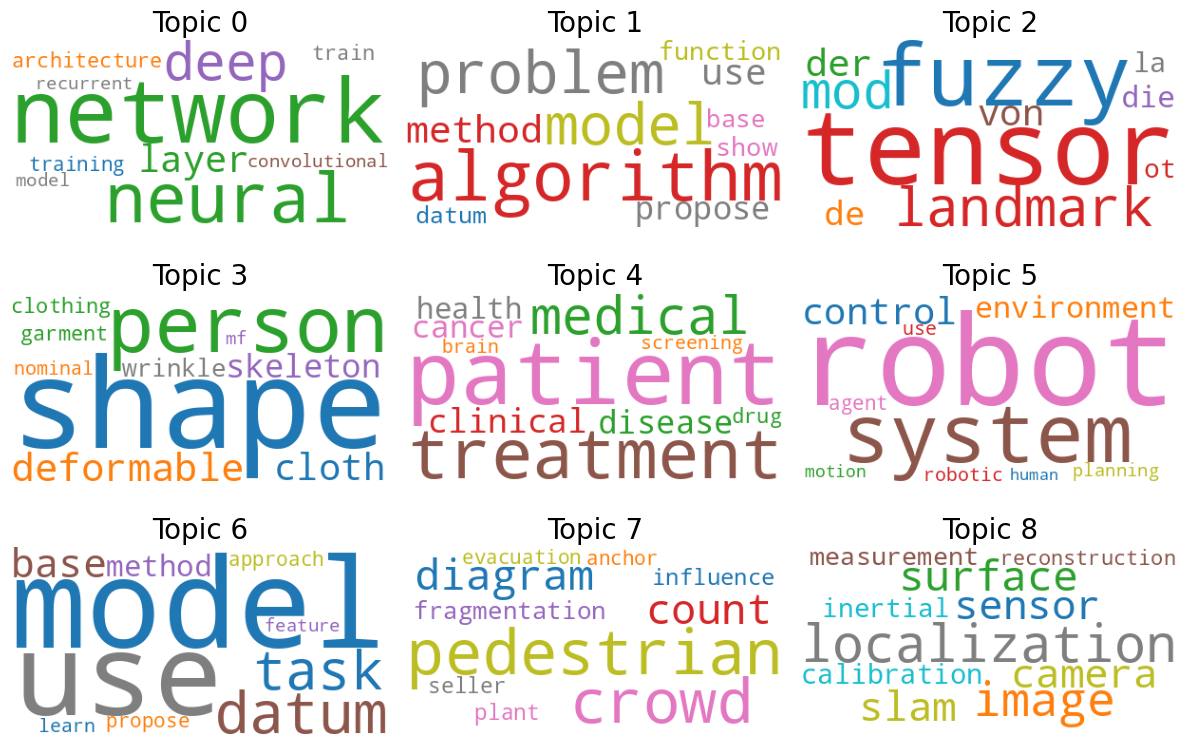

In [39]:
# visualize top topics between 2013 and 2017

# cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
cloud = WordCloud(
    # width=2500,
    # height=2800,
    max_words=10, 
    colormap="tab10",
    stopwords=stop_words,
    prefer_horizontal=1.0,
    background_color="#FFF",
)

topics_first_5 = model_first_5.show_topics(formatted=False)
visualize_topics(cloud, topics_first_5)

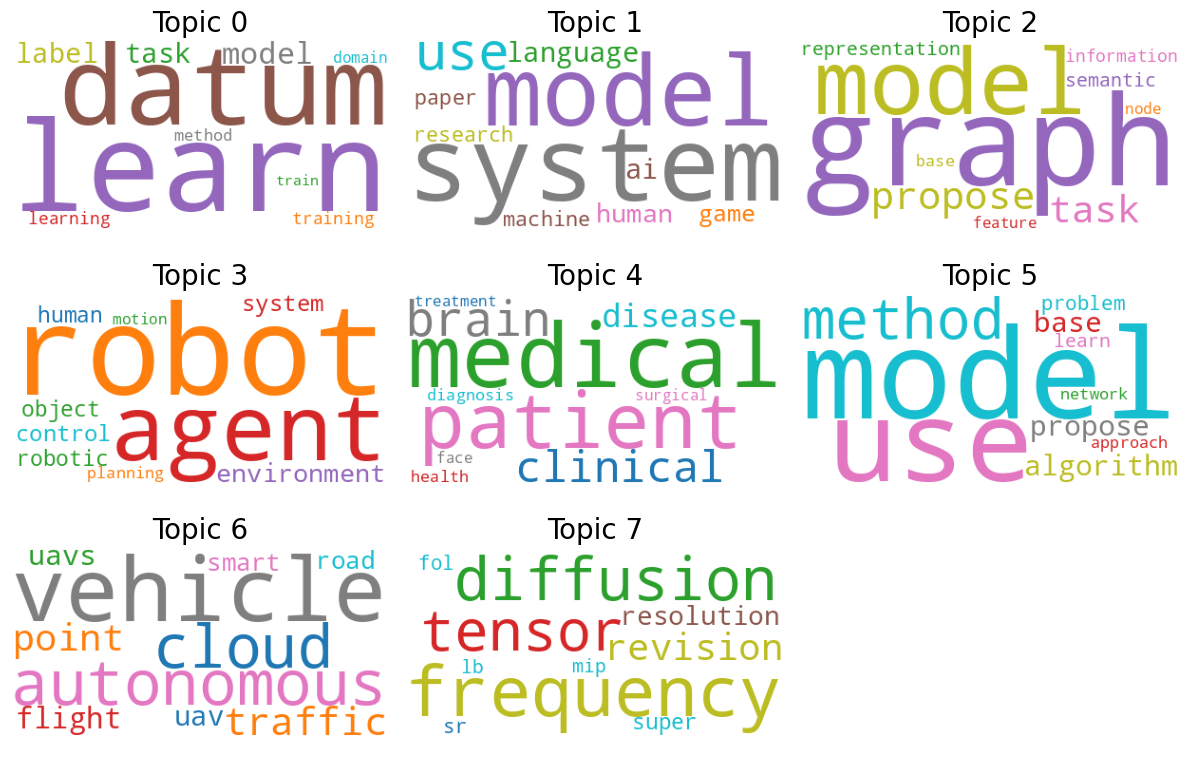

In [40]:
# visualize top topics between 2018 and 2022
topics_last_5 = model_last_5.show_topics(formatted=False)
visualize_topics(cloud, topics_last_5)

## BERTopic

In [41]:
%%time 

# train 2013 - 2017 without a representation model
topic_model_first_5_no_representation = BERTopic(language="english", embedding_model="all-MiniLM-L6-v2")
topics_first_5_no_representation, probs_first_5_no_representation = topic_model_first_5_no_representation.fit_transform(df_first_5["combined_text"])

CPU times: user 32min 59s, sys: 3min 33s, total: 36min 33s
Wall time: 6min 33s


In [42]:
%%time 

# train 2013 - 2017
topic_model_first_5 = BERTopic(language="english", embedding_model="all-MiniLM-L6-v2", representation_model=KeyBERTInspired())
topics_first_5, probs_first_5 = topic_model_first_5.fit_transform(df_first_5["combined_text"])

CPU times: user 35min 48s, sys: 3min 53s, total: 39min 41s
Wall time: 6min 52s


In [43]:
%%time 

# train 2018 - 2022 without a representation model
topic_model_last_5_no_representation = BERTopic(language="english", embedding_model="all-MiniLM-L6-v2")
topics_last_5_no_representation, probs_last_5_no_representation = topic_model_last_5_no_representation.fit_transform(df_last_5["combined_text"])

CPU times: user 35min 5s, sys: 4min 4s, total: 39min 9s
Wall time: 6min 45s


In [44]:
%%time 

# train 2018 - 2022
topic_model_last_5 = BERTopic(language="english", embedding_model="all-MiniLM-L6-v2", representation_model=KeyBERTInspired())
topics_last_5, probs_last_5 = topic_model_last_5.fit_transform(df_last_5["combined_text"])

CPU times: user 38min 36s, sys: 4min 28s, total: 43min 5s
Wall time: 7min 28s


In [45]:
topic_model_first_5.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,3397,-1_deep_learning_neural_recognition,"[deep, learning, neural, recognition, networks...",[Learning to Discover Sparse Graphical Models ...
1,0,177,0_embeddings_word2vec_embedding_corpus,"[embeddings, word2vec, embedding, corpus, nlp,...",[Category Enhanced Word Embedding Distribute...
2,1,167,1_actions_action_videos_activities,"[actions, action, videos, activities, activity...",[Improving Human Action Recognition by Non-act...
3,2,141,2_tracking_tracker_trackers_track,"[tracking, tracker, trackers, track, tracked, ...",[Real-time visual tracking by deep reinforced ...
4,3,137,3_probabilistic_bayesian_inference_bayes,"[probabilistic, bayesian, inference, bayes, be...",[Efficient Search-Based Inference for Noisy-OR...
...,...,...,...,...,...
165,164,11,164_profanity_hateful_corpus_microblogs,"[profanity, hateful, corpus, microblogs, hate,...",[Detecting Online Hate Speech Using Context Aw...
166,165,11,165_bilingual_lingual_translations_wordembeddings,"[bilingual, lingual, translations, wordembeddi...",[Low-resource bilingual lexicon extraction usi...
167,166,11,166_tagging_tags_labeling_annotation,"[tagging, tags, labeling, annotation, flickr, ...",[Image Tag Completion and Refinement by Subspa...
168,167,11,167_stereo_disparity_matching_disparities,"[stereo, disparity, matching, disparities, ben...",[Improved Stereo Matching with Constant Highwa...


In [46]:
topic_model_last_5.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,3457,-1_detection_dataset_images_training,"[detection, dataset, images, training, dataset...",[Transfer Learning for Unseen Robot Detection ...
1,0,294,0_multilingual_lingual_corpus_nlp,"[multilingual, lingual, corpus, nlp, monolingu...",[Syntax Representation in Word Embeddings and ...
2,1,163,1_translations_multilingual_translating_transl...,"[translations, multilingual, translating, tran...",[A General Framework for Adaptation of Neural ...
3,2,162,2_dialogue_dialogues_dialog_conversation,"[dialogue, dialogues, dialog, conversation, co...",[Comprehensive Study: How the Context Informat...
4,3,158,3_actions_action_videos_activities,"[actions, action, videos, activities, activity...",[A Proposal-Based Solution to Spatio-Temporal ...
...,...,...,...,...,...
163,162,10,162_robot_robotics_robotic_robotcore,"[robot, robotics, robotic, robotcore, robots, ...",[iviz: A ROS Visualization App for Mobile Devi...
164,163,10,163_commonsense_commonsenseqa_nlp_knowledge,"[commonsense, commonsenseqa, nlp, knowledge, r...",[Incorporating Commonsense Knowledge Graph in ...
165,164,10,164_activity_activities_videos_tracking,"[activity, activities, videos, tracking, poses...",[Multimodal Generation of Novel Action Appeara...
166,165,10,165_planning_planners_plans_plan,"[planning, planners, plans, plan, agent, agent...",[Learning Action Models from Disordered and No...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


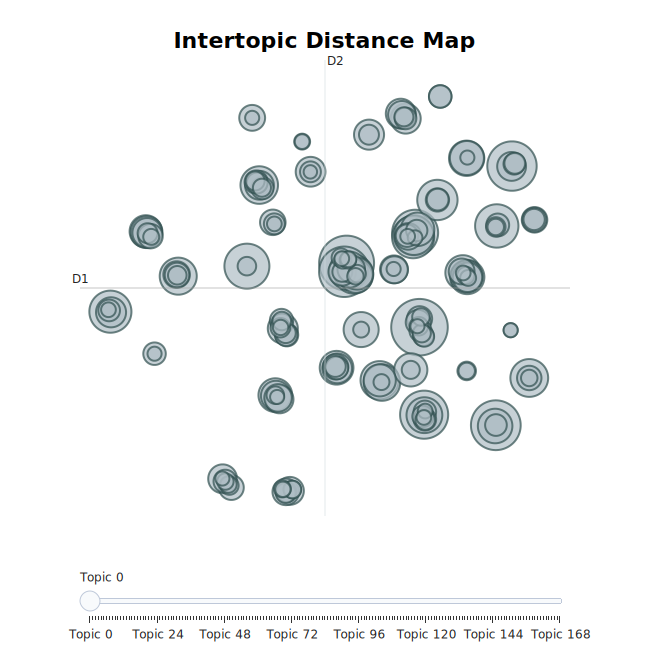

In [47]:
topic_model_first_5.visualize_topics()

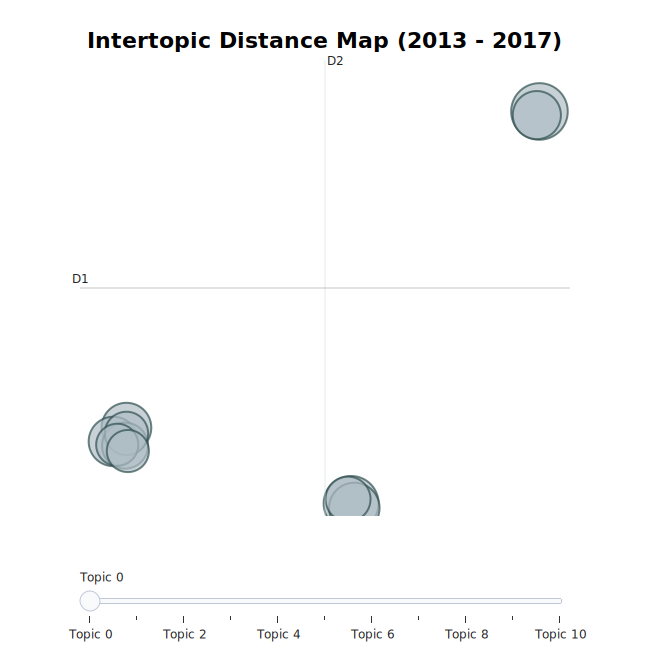

In [48]:
# visualize top 11
topic_model_first_5.visualize_topics(top_n_topics=11, title="<b>Intertopic Distance Map (2013 - 2017)</b>")

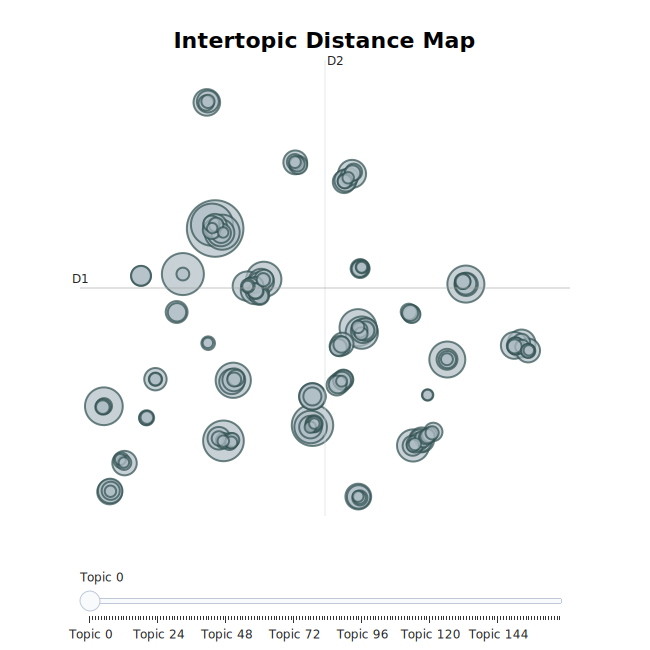

In [49]:
topic_model_last_5.visualize_topics()

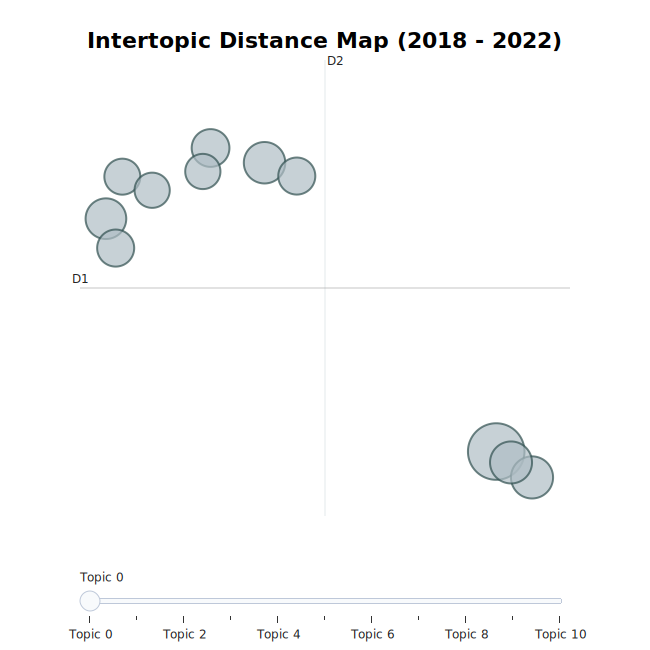

In [50]:
# visualize top 11
topic_model_last_5.visualize_topics(top_n_topics=11, title="<b>Intertopic Distance Map (2018 - 2022)</b>")

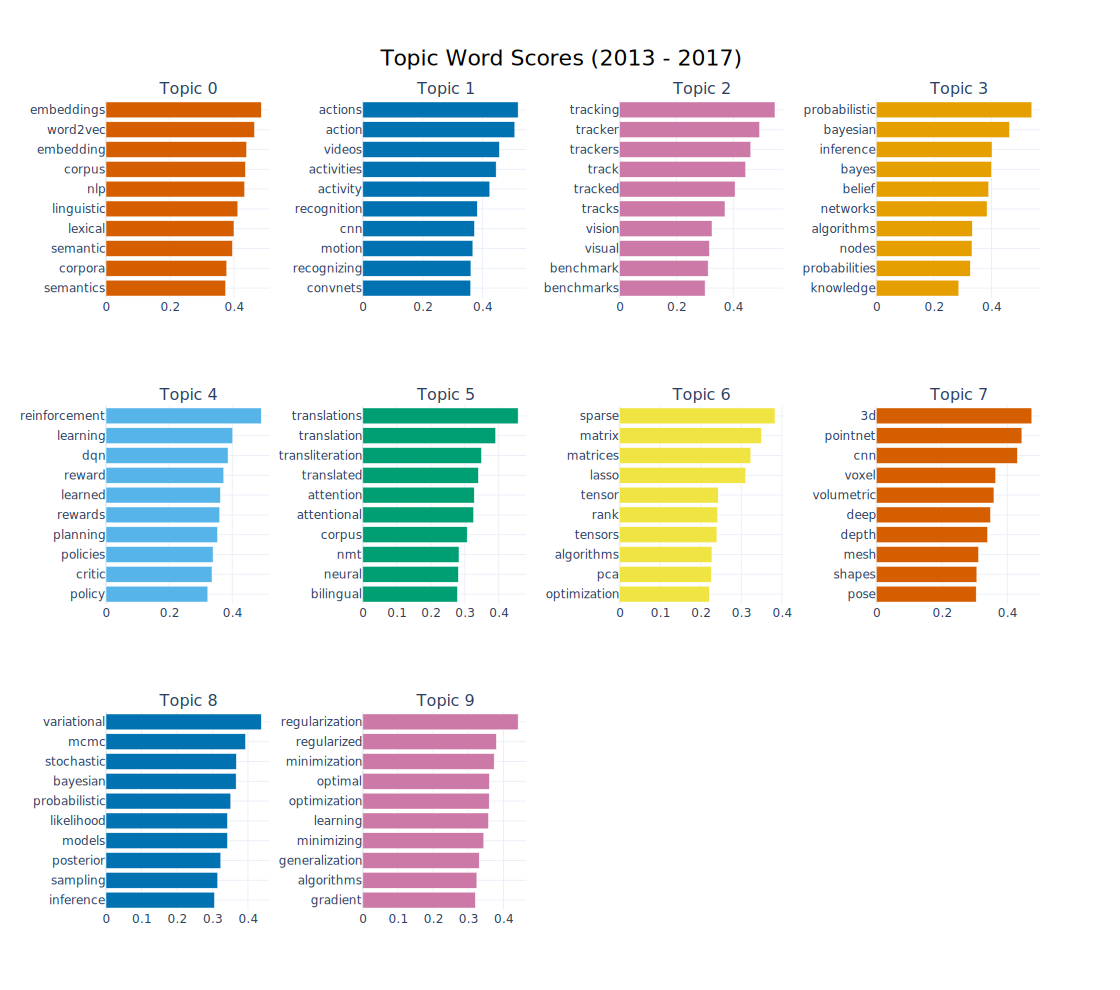

In [51]:
topic_model_first_5.visualize_barchart(width=280, height=330, top_n_topics=10, n_words=10, title="Topic Word Scores (2013 - 2017)")

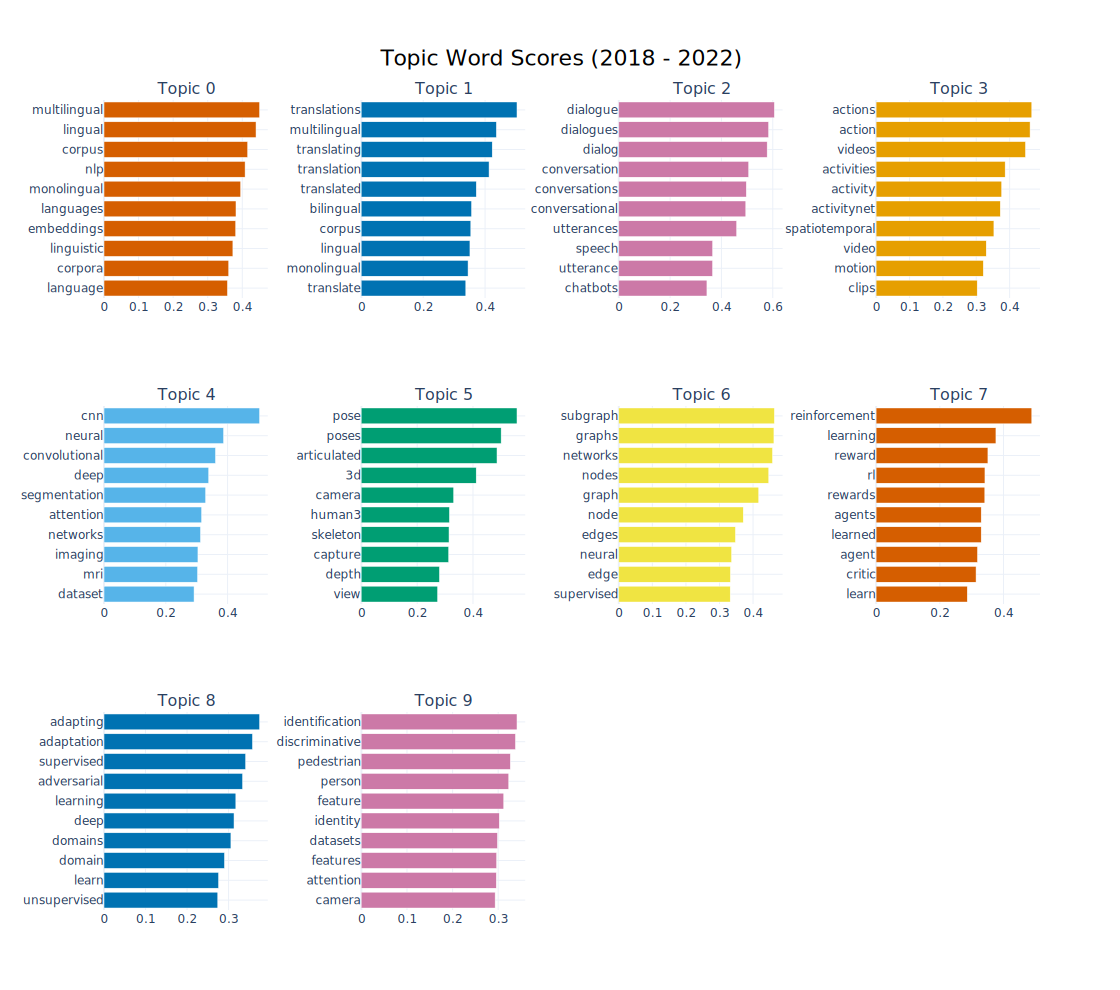

In [52]:
topic_model_last_5.visualize_barchart(width=280, height=330, top_n_topics=10, n_words=10, title="Topic Word Scores (2018 - 2022)")

In [53]:
# coherence val for 2013 - 2017 (no representation model)
calculate_bert_coherence_val(topic_model_first_5_no_representation, processed_series_first_5, id2word_first_5)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

0.6248034174352352

In [54]:
# coherence val for 2013 - 2017
calculate_bert_coherence_val(topic_model_first_5, processed_series_first_5, id2word_first_5)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

0.503496523720864

In [55]:
# coherence val for 2018 - 2022 (no representation model)
calculate_bert_coherence_val(topic_model_last_5_no_representation, processed_series_last_5, id2word_last_5)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

0.6486735735390204

In [56]:
# coherence val for 2018 - 2022
calculate_bert_coherence_val(topic_model_last_5, processed_series_last_5, id2word_last_5)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

0.5843384065355386

CPU times: user 11min 23s, sys: 1min 12s, total: 12min 35s
Wall time: 2min 19s


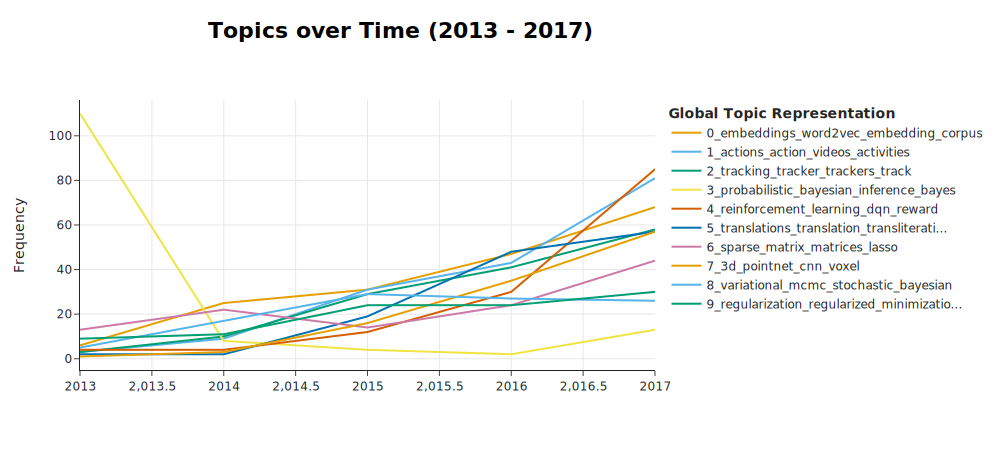

In [57]:
%%time 

topics_over_time_first_5 = topic_model_first_5.topics_over_time(df_first_5["combined_text"], df_first_5["publish_date"].dt.year)
topic_model_first_5.visualize_topics_over_time(topics_over_time_first_5, topics=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], width=1000, title="<b>Topics over Time (2013 - 2017)</b>",)

CPU times: user 12min 7s, sys: 1min 20s, total: 13min 27s
Wall time: 2min 27s


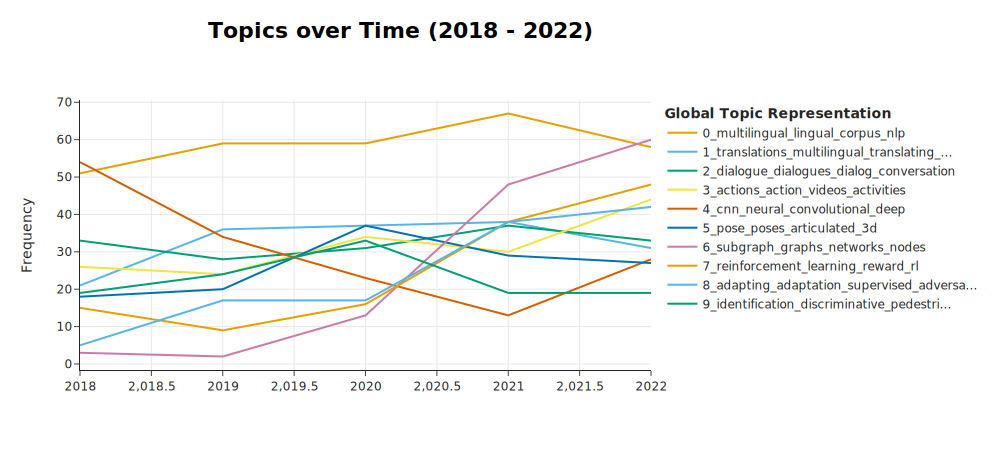

In [58]:
%%time 

topics_over_time_last_5 = topic_model_last_5.topics_over_time(df_last_5["combined_text"], df_last_5["publish_date"].dt.year)
topic_model_last_5.visualize_topics_over_time(topics_over_time_last_5, topics=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], width=1000, title="<b>Topics over Time (2018 - 2022)</b>",)